In [2]:
import cv2

In [3]:
import picamera2

In [3]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

[ WARN:0] global /tmp/pip-wheel-hwcmjluw/opencv-python_dc56ddd000dd4893b1f852d88d4a5959/opencv/modules/videoio/src/cap_v4l.cpp (890) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


In [4]:
import matplotlib.pyplot as plt

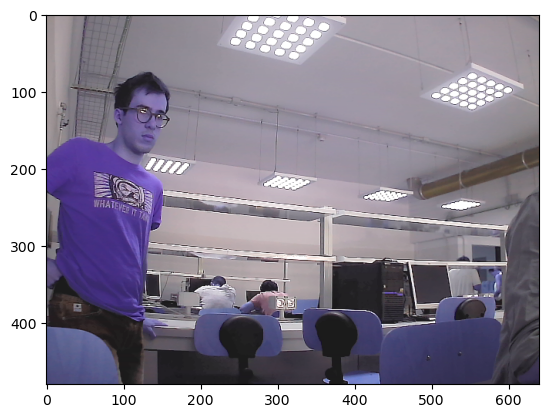

In [5]:
plt.imshow(frame)

In [5]:
import time

[1:24:53.011970324] [5841]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70
[1:24:53.047930815] [5878]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[1:24:53.049109078] [5878]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/imx219@10 to Unicam device /dev/media0 and ISP device /dev/media2
[1:24:53.059209633] [5841]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888
[1:24:53.059728573] [5878]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/imx219@10 - Selected sensor format: 640x480-SBGGR10_1X10 - Selected unicam format: 640x480-pBAA


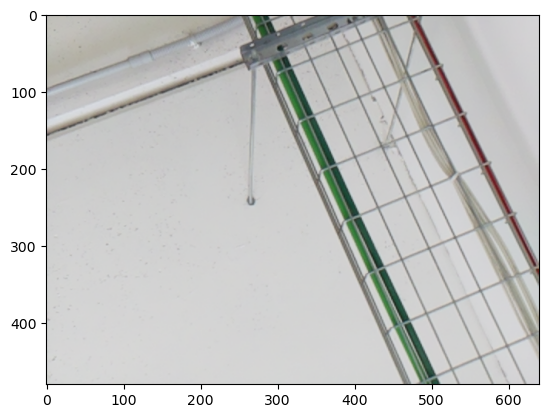

In [6]:
with picamera2.Picamera2() as camera:
    camera.start()
    time.sleep(1)
    array = camera.capture_array('main')
    plt.imshow(array)

In [6]:
camera = picamera2.Picamera2()
camera.start()

[0:02:42.307524421] [1357]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70
[0:02:42.362166199] [1447]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:02:42.363294403] [1447]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/imx219@10 to Unicam device /dev/media0 and ISP device /dev/media2
[0:02:42.472428551] [1357]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888
[0:02:42.473260588] [1447]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/imx219@10 - Selected sensor format: 640x480-SBGGR10_1X10 - Selected unicam format: 640x480-pBAA


In [7]:
frame2 = camera.capture_array('main')

In [9]:
frame2.shape

(480, 640, 4)

In [1]:
import cv2
import picamera2
import numpy as np
import pandas as pd
import time

In [7]:
import time

In [2]:
def saveVideo(frames, path, fps=29):
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    size = (frames[0].shape[1], frames[0].shape[0])
    out = cv2.VideoWriter(path, fourcc, fps, size)
    for frame in frames:
        out.write(frame)
    out.release()

#initialize result dataframe
result = pd.DataFrame(columns=['frame', 'x', 'y'])

def get_centroid(contour):
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0
    return (cX, cY)

kalman = cv2.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32) * 0.001
kalman.measurementNoiseCov = np.array([[1, 0], [0, 1]], np.float32) * 0.2
def trigger(camName):
    color_treshold = 40
    if(camName=="std"):
        cv2.namedWindow("frame", cv2.WINDOW_NORMAL)
        cap = cv2.VideoCapture(2)
        ret, prev_frame = cap.read()

        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        prev_gray = cv2.GaussianBlur(prev_gray, (11, 11), 0)
        
        #init kalman filter, first frame
        init = False
        
        #to save video
        video_frames = []
        
        frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
        print(f"frmae height is{frame_height}")
        w=5
        while cap.isOpened():
            intensity_sum = 0
            ret, frame = cap.read()
            if not ret:
                break
        
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (11, 11), 0)
        
            frame_diff = cv2.absdiff(gray, prev_gray)
        
            _, thresh = cv2.threshold(frame_diff, 10, 255, cv2.THRESH_BINARY)
        
            kernel = np.ones((5,5),np.uint8)
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
            
            #take orizontal line from 600 to 680 pixels
            line = thresh[int(frame_height/2)-w:int(frame_height/2)+w, :]
            #sum all the pixels in the line
            intensity_sum = np.sum(line)
            #normalize the sum between 0 and 255
            intensity_sum = (intensity_sum/255)/80
            #drow a circle in the frame to show intensity sum, more intense make it whiter
            color = int(intensity_sum*255)
            cv2.circle(thresh, (int(frame_width/2), int(frame_height/2)), 40, (color, color, color), 2)
            if color >= color_treshold:
                cv2.circle(thresh, (int(frame_width/2), int(frame_height/2)), 40, (color, color, color), 2)
                cv2.imshow("frame", thresh)
                cap.release()
                cv2.destroyWindow("frame")
                print(f"START AT:{time.time()}")
                return 1
            #show the frame
            cv2.imshow("frame", thresh)
            
        
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
            time.sleep(0.1)
        
            prev_gray = gray
        
        cap.release()
        cv2.destroyAllWindows()
    else:
        cv2.namedWindow("frame2", cv2.WINDOW_NORMAL)
        camera = picamera2.Picamera2()
        camera.start()
        prev_frame = camera.capture_array('main')
        frame_width = 640
        frame_height = 480
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        prev_gray = cv2.GaussianBlur(prev_gray, (11, 11), 0)
        
        #init kalman filter, first frame
        init = False
        
        #to save video
        video_frames = []
        print(f"frmae height is{frame_height}")
        w=5
        # while cap.isOpened():
        while(True):
            intensity_sum = 0
            frame = camera.capture_array('main')
            # if not ret:
            #     break
        
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (11, 11), 0)
        
            frame_diff = cv2.absdiff(gray, prev_gray)
        
            _, thresh = cv2.threshold(frame_diff, 10, 255, cv2.THRESH_BINARY)
        
            kernel = np.ones((5,5),np.uint8)
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
            
            
            line = thresh[int(frame_height/2)-w:int(frame_height/2)+w, :]
            #sum all the pixels in the line
            intensity_sum = np.sum(line)
            #normalize the sum between 0 and 255
            intensity_sum = (intensity_sum/255)/(2*w)
            #drow a circle in the frame to show intensity sum, more intense make it whiter
            color = int(intensity_sum*255)
            #show the frame
            cv2.circle(thresh, (int(frame_width/2), int(frame_height/2)), 40, (color, color, color), 2)
            if color >= color_treshold:
                cv2.circle(thresh, (int(frame_width/2), int(frame_height/2)), 40, (color, color, color), 2)
                cv2.imshow("frame2", thresh)
                camera.close()
                print(f"START AT:{time.time()}")
                cv2.destroyWindow("frame2")
                return 1
            
            cv2.imshow("frame2", thresh)
                    
        
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
            time.sleep(0.1)
        
            prev_gray = gray

        
        cap.release()
        cv2.destroyAllWindows()
    
    

In [3]:
trigger("mooseca")

[0:24:56.854683557] [2857]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70
[0:24:56.921381589] [3033]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:24:56.923148073] [3033]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/imx219@10 to Unicam device /dev/media0 and ISP device /dev/media1
[0:24:56.997059313] [2857]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888
[0:24:56.997483518] [3033]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/imx219@10 - Selected sensor format: 640x480-SBGGR10_1X10 - Selected unicam format: 640x480-pBAA


frmae height is480
START AT:1693995779.9136248


1

In [3]:
from concurrent.futures import ThreadPoolExecutor

In [4]:
first = (trigger,"std")
second = (trigger,"mooseca")
func, *args = first
p1 = Process(target=func, args=args)
p1.start()
func, *args = second
p2 = Process(target=func, args=args)
p2.start()
p1.join()
p2.join()

NameError: name 'Process' is not defined

In [6]:
params_list = ["std", ""]
with ThreadPoolExecutor() as executor:
    executor.map(trigger, params_list)
cv2.destroyAllWindows()

[0:30:42.220703832] [3414]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70
[0:30:42.285717344] [3415]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:30:42.287588789] [3415]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/imx219@10 to Unicam device /dev/media0 and ISP device /dev/media1
[0:30:42.310215393] [3414]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888
[0:30:42.314169394] [3415]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/imx219@10 - Selected sensor format: 640x480-SBGGR10_1X10 - Selected unicam format: 640x480-pBAA


frmae height is480
frmae height is480.0
START AT:1693996124.3353052
START AT:1693996130.5460725


In [13]:
camera = picamera2.Picamera2()

Camera __init__ sequence did not complete.
[1:25:54.784489812] [5841] ERROR Camera camera.cpp:526 Camera in Acquired state trying acquire() requiring state Available


RuntimeError: Camera __init__ sequence did not complete.

In [11]:
camera.close()

NameError: name 'camera' is not defined